# Import 

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [85]:
import numpy as np
from scipy.ndimage import convolve, gaussian_filter, median_filter, binary_fill_holes
import random
import copy
from skimage import (exposure, feature, filters, io, measure,
                      morphology, restoration, segmentation, transform,
                      util)
from skimage.filters import threshold_mean,threshold_local,threshold_otsu
import matplotlib.patches as mpatches

from skimage import data
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square,diameter_opening,area_opening,binary_erosion
from skimage.color import label2rgb


import napari
import cv2

import matplotlib.pyplot as plt
import scipy.io

from make_graphs import *

# Image 

In [13]:
mat = scipy.io.loadmat('Data/MRIdata.mat')

In [14]:
vol = mat['vol']
pixdim = mat['pixdim']
dim = mat['dim']

In [15]:
slice_135 = vol[135,:,:]

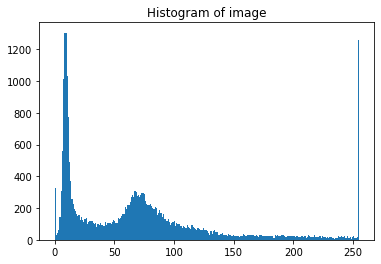

In [16]:
histogram_image(slice_135, title="Histogram of image", nb_bins=256, file_path=None)

# Preprocessing 

In [17]:
denoised = median_filter(slice_135,5)

# Otsu 135 

In [18]:
image = denoised

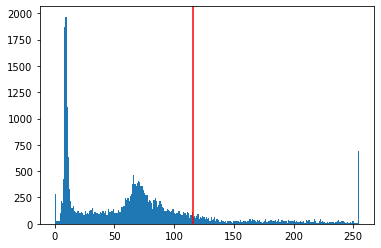

In [19]:
# apply threshold
thresh = threshold_otsu(image)

plt.figure()
plt.hist(image.flatten(), bins=256)
plt.axvline(thresh,color = 'r')
plt.show()


In [20]:
# remove artifacts connected to image border
bw = closing(image > thresh, square(3))

In [21]:
cleared = clear_border(bw)

In [22]:
label_image = label(cleared)

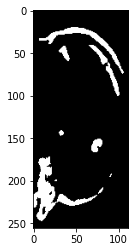

In [23]:
plt.imshow(image > thresh,cmap="gray")
plt.show()

202
(158.62376237623764, 73.8019801980198)
13


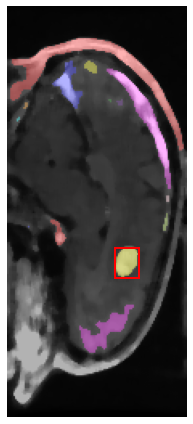

In [25]:
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        if (minr<= seed[0]<=maxr) and minc<= seed[1]<=maxc:
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            print(region.area)
            print(region.centroid)
            print(region.label)

ax.set_axis_off()
plt.tight_layout()
plt.show()

# Generalization 

In [116]:
vol_denoised = median_filter(vol,5)

In [117]:
new_vol = np.zeros(np.shape(vol))

In [118]:
slice_135 = vol_denoised[135,:,:]

In [119]:
thresh = threshold_otsu(slice_135)

In [120]:
seed =[159,75]
for k in range(135,-1,-1):
    slice_sagittal = vol_denoised[k,:,:]
    image = slice_sagittal
    bw = closing(image > thresh, square(3))
    cleared = clear_border(bw)
    label_image = label(cleared)
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        if (minr<= seed[0]<=maxr) and minc<= seed[1]<=maxc and region.area<1500:
            #print(k,region.label,region.area)
            label_image[label_image != region.label]=0
            label_image[label_image!=0]=255
            new_vol[k]=binary_erosion(label_image)
            

In [121]:
for k in range(136,np.shape(vol)[0]):
    slice_sagittal = vol_denoised[k,:,:]
    image = slice_sagittal
    bw = closing(image > thresh, square(3))
    cleared = clear_border(bw)
    label_image = label(cleared)
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        if (minr<= seed[0]<=maxr) and minc<= seed[1]<=maxc and region.area<1500:
            #print(k,region.label,region.area)
            label_image[label_image != region.label]=0
            label_image[label_image!=0]=255
            new_vol[k]=binary_erosion(label_image)

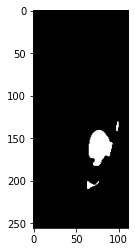

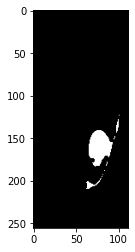

In [133]:
plt.imshow(median_filter(new_vol[128,:,:],3),cmap="gray")

In [123]:
viewer = napari.view_image(new_vol)

In [124]:
import napari

In [134]:
new_vol = median_filter(new_vol,3)

In [135]:
final = vol*0.3 + new_vol*255
final[final>255] =255

In [136]:
viewer = napari.view_image(final)

In [50]:
print(new_vol[99,159,75])

0.0


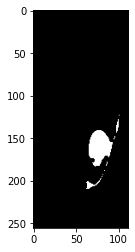

In [87]:
plt.imshow(binary_erosion(new_vol[128,:,:]),cmap="gray")